# Gravity Tech Test - EDA
***
**Author:** Mauricio Jacome  
**Date:** 31-Aug-2022  
**Objective**: Build Credit Scoring model from limited dataset

In [1]:
# Environment Setup and dependencies
import numpy as np  # Array manipulation
import pandas as pd  # Dataframe Manipulation

from math import exp, log
import utils

from matplotlib import pyplot as plt
import seaborn as sns

# Model and Classiffication
from sklearn.ensemble import RandomForestClassifier  # Classification Models
from sklearn.model_selection import train_test_split  # Shuffling and Test data
from sklearn.metrics import roc_auc_score   # Metrics

### Load Dataset
The working dataset has a size of 700kb, we will open this using the main tool for data wrangling, Pandas.

In [3]:
# Import Data, clean headers
df =pd.read_csv('loan_data.csv', header= 0, names=['credit_policy','purpose',
'int_rate',
'installment',
'log_annual_inc',
'dti',
'fico',
'days_with_cr_line',
'revol_bal',
'revol_util',
'inq_last_6mths',
'delinq_2yrs',
'pub_rec',
'not_fully_paid'])

print("Dimension of the dataset is:", df.shape)
df.head()  # Top 5 rows from dataframe

Dimension of the dataset is: (9578, 14)


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
df.info() # Check information from the dataframe, non null type, number of columns, Dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  not_fully_paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


Some columns do not match the initial initial expectations, credit policy should be a boolean value, some initial toughts on ratios seem worrying. I'll rename our target feature and check for null values

In [5]:
df.rename(columns={'not_fully_paid': 'target'}, inplace=True)

In [6]:
df.isnull().sum()  # No null values we are good to go.

credit_policy        0
purpose              0
int_rate             0
installment          0
log_annual_inc       0
dti                  0
fico                 0
days_with_cr_line    0
revol_bal            0
revol_util           0
inq_last_6mths       0
delinq_2yrs          0
pub_rec              0
target               0
dtype: int64

## Target Analysis

Distribution, plots, and initial views on features

In [7]:
df['target'].describe()  # Check behaviour of the target over data universe

count    9578.000000
mean        0.160054
std         0.366676
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: target, dtype: float64

<AxesSubplot:xlabel='count', ylabel='target'>

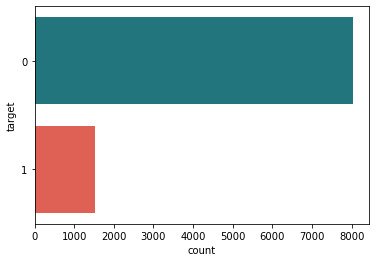

In [8]:
sns.countplot(y= df['target'], orient ='h', palette=['#13828c',"#F64D3E"])

In [9]:
df.groupby(by=['target']).mean()  # Check univariate for each feature universe

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
target,,,,,,,,,,,,
0,0.832318,0.120770,314.574123,10.941091,12.494413,713.326911,4592.632624,16122.724425,45.759608,1.433934,0.161591,0.056557
1,0.661448,0.132452,342.785114,10.885023,13.195838,697.828441,4393.541259,21066.293542,52.255075,2.330724,0.174821,0.091324


- Target feature is: Is not fully paid
- Average of 16% of the population have not fully paid in the whole sample. 
- Income does not seem to be super relevant for our population shift.
- Fico scores help the model but should be removed for policy sake. 
- Debt to income ratios are insanely high, probably mortgages. 

## Feature Exploration: Numerical Features

<AxesSubplot:xlabel='int_rate', ylabel='Count'>

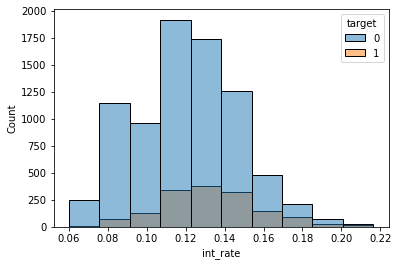

In [10]:
# Interest Rate
sns.histplot(x=df['int_rate'], hue=df['target'], bins=10)

**What worries me about this feature?**  
Bias from policy. Low default to low interest rate customers suggests that premium customers in credit risk get premium interest rates. 

<AxesSubplot:xlabel='log_annual_inc', ylabel='Count'>

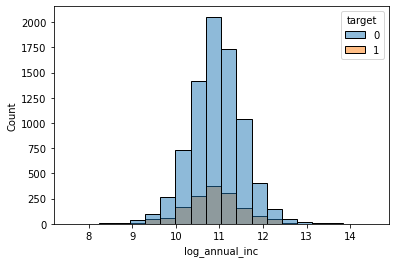

In [11]:
# Annual Income (Log) 
sns.histplot(x=df['log_annual_inc'], hue=df['target'], bins=20)

**What worries me about this feature?**  
- Income distribution does not seem so suggest lower default rate, maybe not entirely verified income population.  
- Tails, should be windsorized to avoid losing predictive power. 

<AxesSubplot:xlabel='installment', ylabel='Count'>

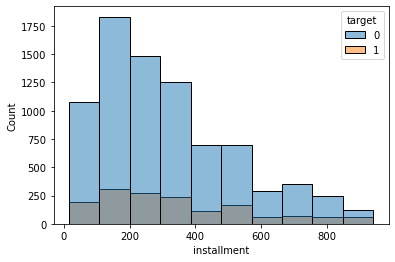

In [12]:
# Installment
sns.histplot(x=df['installment'], hue=df['target'], bins=10)

**What worries me about this feature?**  
- No clear definition for installment. High Installments should be correlated to high default rates but they do not seem so be correlated. 


<AxesSubplot:xlabel='dti', ylabel='Count'>

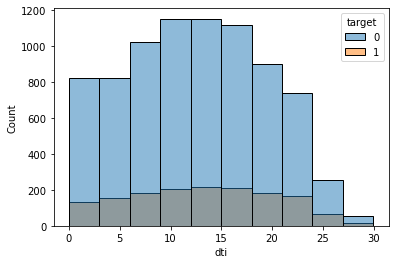

In [13]:
# Debt To Income
sns.histplot(x=df['dti'], hue=df['target'], bins=10)

**What worries me about this feature?**  
- Debt to total income is off the charts, this suggests BIG loans but given above income distribution is also seems to suggest variety in the credit lines. 
- Bias on policy, 25+ DTI is a nogo

<AxesSubplot:xlabel='fico', ylabel='Count'>

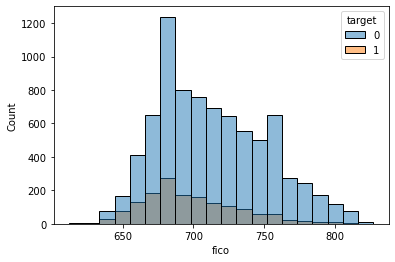

In [14]:
# FICO Score
sns.histplot(x=df['fico'], hue=df['target'], bins=20)

**What worries me about this feature?**  
- Bias on policy 800+ , 600- This needs to be addressed in model construction and suggestions 600- is a no go zone for the current data

<AxesSubplot:xlabel='days_with_cr_line', ylabel='Count'>

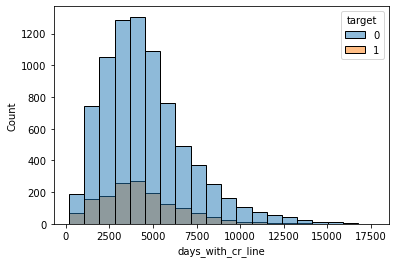

In [15]:
# days_with_cr_line
sns.histplot(x=df['days_with_cr_line'], hue=df['target'], bins=20)

**What worries me about this feature?**  
- Does not worry, Feature goes in line with literature. 
- <1 year should be riskier on most portfolios, this suggests additional policies we are not catching. 

In [16]:
df['revol_bal'].describe(percentiles=[.25,.5,.75,.95])

count    9.578000e+03
mean     1.691396e+04
std      3.375619e+04
min      0.000000e+00
25%      3.187000e+03
50%      8.596000e+03
75%      1.824950e+04
95%      5.765430e+04
max      1.207359e+06
Name: revol_bal, dtype: float64

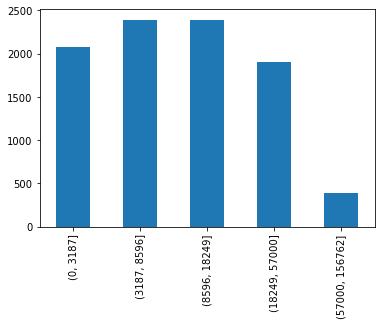

In [17]:
# revol_bal
data =pd.DataFrame()
data['revol_bal_binned'] = pd.cut(x=df['revol_bal'], bins=[0, 3187,8596,18249,57000, 156762])
data['revol_bal_binned'].value_counts(sort=False).plot.bar()
data['target'] = df['target']

<AxesSubplot:xlabel='revol_bal_binned'>

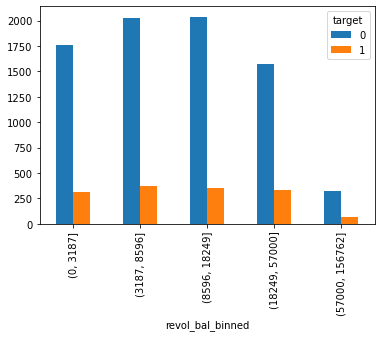

In [18]:
data.groupby(['revol_bal_binned',"target"]).size().unstack().plot.bar()

**What worries me about this feature?**  
- Outliers need to be treated
- Fairly homogeneus, there should be a breaking point of revolving balance were we can see a split. 

<AxesSubplot:xlabel='revol_util', ylabel='Count'>

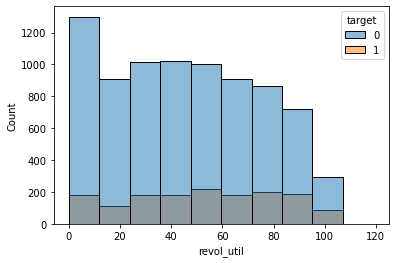

In [19]:
# Revolving Utilization
sns.histplot(x=df['revol_util'], hue=df['target'], bins=10)

**What worries me about this feature?**  
- Does not follow common patterns in credit, high utilization should drive higher defaults in a starker way. 
- low pockets of utilization should be modelled separately

In [24]:
# Inquiries in the last month (Footprints)
df['inq_last_6mths'].describe(percentiles=[.25,.5,.75,.95])

count    9578.000000
mean        1.577469
std         2.200245
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
95%         5.000000
max        33.000000
Name: inq_last_6mths, dtype: float64

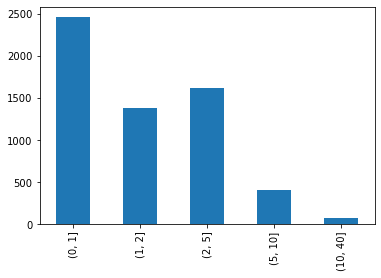

In [25]:
data = pd.DataFrame()
data['inq_last_6mths_binned'] = pd.cut(x=df['inq_last_6mths'], bins=[0, 1,2,5,10,40])
data['inq_last_6mths_binned'].value_counts(sort=False).plot.bar()
data['target'] = df['target']

<AxesSubplot:xlabel='inq_last_6mths_binned'>

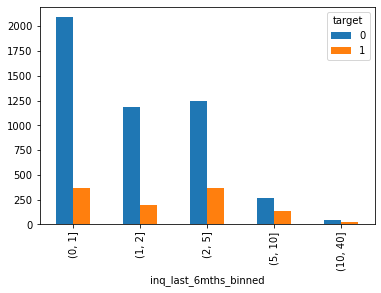

In [27]:
data.groupby(['inq_last_6mths_binned',"target"]).size().unstack().plot.bar()

**What worries me about this feature?**  
- Illegal to use for credit scoring under some jurisdictions
- Outliers need to be treated 
- Candidate for categorical

### Categorical features

In [30]:
# delinq_2yrs
df['delinq_2yrs'].describe(percentiles=[.25,.5,.75,.95])


count    9578.000000
mean        0.163708
std         0.546215
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
95%         1.000000
max        13.000000
Name: delinq_2yrs, dtype: float64

**What worries me about this feature?**  
- High correlation with target, candidate to drop

In [35]:
# Pub_rec
df[['pub_rec', 'target']].value_counts()

pub_rec  target
0        0         7624
         1         1395
1        0          397
         1          136
2        0           17
3        0            5
2        1            2
5        0            1
4        0            1
dtype: int64

**What worries me about this feature?**  
- Low Cardinality, candidate to drop
- Cannot really understand the logic behind the feature name, will not use to model if I cannot understand it

In [37]:
# credit_policy
df[['credit_policy', 'target']].value_counts()

credit_policy  target
1              0         6696
0              0         1349
1              1         1014
0              1          519
dtype: int64

**What worries me about this feature?**  
- Clear bias in policies, I suggest to use it as business segment

In [40]:
# purpose
df[['purpose']].value_counts()

purpose           
debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
dtype: int64

**What worries me about this feature?**  
- Clear bias purposes, cannot mix SMB with debt consolidation, or credit cards
- Low cardinality on business segments, low default rate on some purpose loans
- Debt consolidation will increase fico scores of customers. Careful on Policy implementation